In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.stattools import adfuller, coint
from statistics import linear_regression
from scipy.optimize import minimize
from scipy.stats import norm

def stationarity_test(series):
    result = adfuller(series)
    print(f"ADF statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    if result[1] < 0.05:
        print("Stationary at 0.05 significance level")
        # compute series mean and std
        mean = np.mean(series)
        std = np.std(series)
        print(f"Mean: {mean:.3f}")
        print(f"Standard Deviation: {std:.3f}")
    else:
        print("Not stationary at 0.05 significance level")

def cointegration_test(series1, series2):
    score, p_value, _ = coint(series1, series2)
    print(f"Engle-Granger test statistic: {score:.3f}")
    print(f"p-value: {p_value:.3f}")
    if p_value < 0.05:
        print("Cointegrated at 0.05 significance level")
    else:
        print("Not cointegrated at 0.05 significance level")

def estimate_ou_mle(x, dt=1.0):
    def neg_log_likelihood(params):
        theta, mu, sigma = params
        if sigma <= 0 or theta <= 0:
            return np.inf  # invalid parameter region

        x_prev = x[:-1]
        x_next = x[1:]

        # Conditional mean and variance from OU transition
        e_theta_dt = np.exp(-theta * dt)
        mean = mu + (x_prev - mu) * e_theta_dt
        variance = (sigma**2) / (2 * theta) * (1 - e_theta_dt**2)

        # Log-likelihood
        ll = norm.logpdf(x_next, loc=mean, scale=np.sqrt(variance))
        return -np.sum(ll)  # negative log-likelihood

    # Initial guesses
    theta0 = 0.5
    mu0 = np.mean(x)
    sigma0 = np.std(x)
    initial_guess = [theta0, mu0, sigma0]

    result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B',
                      bounds=[(1e-5, None), (None, None), (1e-5, None)])

    if result.success:
        theta_mle, mu_mle, sigma_mle = result.x
        return theta_mle, mu_mle, sigma_mle
    else:
        raise RuntimeError("MLE optimization failed: " + result.message)

def ou_process(theta, mu, sigma, n_steps=1000, dt=1.0):
    x = np.zeros(n_steps)
    x[0] = mu  # Start at the mean
    for i in range(1, n_steps):
        dx = theta * (mu - x[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        x[i] = x[i-1] + dx
    return x

In [3]:
from math import log, sqrt, exp, erf
from statistics import NormalDist


class BlackScholes:

    # @staticmethod
    # def erf_vec(x):
    #     return np.vectorize(erf)(x)

    @staticmethod
    def normal_cdf(x):
        # return 0.5 * (1 + BlackScholes.erf_vec(x / np.sqrt(2)))
        return NormalDist().cdf(x)
    
    @staticmethod
    def normal_pdf(x):
        return np.exp(-0.5 * x * x) / np.sqrt(2 * np.pi)

    @staticmethod
    def d1(spot, strike, time_to_expiry, volatility):
        return (
            np.log(spot / strike)
            + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * np.sqrt(time_to_expiry))
    
    @staticmethod
    def d2(spot, strike, time_to_expiry, volatility):
        return BlackScholes.d1(spot, strike, time_to_expiry, volatility) - (
            volatility * np.sqrt(time_to_expiry)
        )

    @staticmethod
    def black_scholes_call(spot, strike, time_to_expiry, volatility):
        d1 = BlackScholes.d1(spot, strike, time_to_expiry, volatility)
        d2 = BlackScholes.d2(spot, strike, time_to_expiry, volatility)
        call_price = spot*BlackScholes.normal_cdf(d1) - strike*BlackScholes.normal_cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_expiry, volatility):
        d1 = BlackScholes.d1(spot, strike, time_to_expiry, volatility)
        d2 = BlackScholes.d2(spot, strike, time_to_expiry, volatility)
        put_price = strike*BlackScholes.normal_cdf(-d2) - spot*BlackScholes.normal_cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_expiry, volatility):
        d1 = BlackScholes.d1(spot, strike, time_to_expiry, volatility)
        return BlackScholes.normal_cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_expiry, volatility):
        d1 = BlackScholes.d1(spot, strike, time_to_expiry, volatility)
        return BlackScholes.normal_pdf(d1) / (spot * volatility * np.sqrt(time_to_expiry))

    @staticmethod
    def vega(spot, strike, time_to_expiry, volatility):
        d1 = BlackScholes.d1(spot, strike, time_to_expiry, volatility)
        # print(f"d1: {d1}")
        # print(f"vol: {volatility}")
        # print(f"spot: {spot}")
        # print(f"strike: {strike}")
        # print(f"time: {time_to_expiry}")
        return BlackScholes.normal_pdf(d1) * (spot * np.sqrt(time_to_expiry)) / 100

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10
    ):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = BlackScholes.black_scholes_call(
                spot, strike, time_to_expiry, volatility
            )
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility


In [4]:
prices_1 = pd.read_csv('./round-4-island-data-bottle/prices_round_4_day_1.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')
prices_2 = pd.read_csv('./round-4-island-data-bottle/prices_round_4_day_2.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')
prices_3 = pd.read_csv('./round-4-island-data-bottle/prices_round_4_day_3.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')
# trades_1 = pd.read_csv('./round-4-island-data-bottle/trades_round_4_day_1.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')
# trades_2 = pd.read_csv('./round-4-island-data-bottle/trades_round_4_day_2.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')
# trades_3 = pd.read_csv('./round-4-island-data-bottle/trades_round_4_day_3.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')

PRODUCTS = set(prices_1['product'])
PRODUCTS
OPTIONS = [
    'VOLCANIC_ROCK_VOUCHER_10000',
    'VOLCANIC_ROCK_VOUCHER_10250',
    'VOLCANIC_ROCK_VOUCHER_10500',
    'VOLCANIC_ROCK_VOUCHER_9500',
    'VOLCANIC_ROCK_VOUCHER_9750']
STRIKES = [10000, 10250, 10500, 9500, 9750]

PRODUCTS

/var/folders/fw/cl62311d3y1_dgsvr1tft4f80000gn/T/ipykernel_9717/2543738880.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  prices_1 = pd.read_csv('./round-4-island-data-bottle/prices_round_4_day_1.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')
/var/folders/fw/cl62311d3y1_dgsvr1tft4f80000gn/T/ipykernel_9717/2543738880.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  prices_2 = pd.read_csv('./round-4-island-data-bottle/prices_round_4_day_2.csv', delimiter=';').apply(pd.to_numeric, errors='ignore')
/var/folders/fw/cl62311d3y1_dgsvr1tft4f80000gn/T/ipykernel_9717/2543738880.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pr

{'CROISSANTS',
 'DJEMBES',
 'JAMS',
 'KELP',
 'MAGNIFICENT_MACARONS',
 'PICNIC_BASKET1',
 'PICNIC_BASKET2',
 'RAINFOREST_RESIN',
 'SQUID_INK',
 'VOLCANIC_ROCK',
 'VOLCANIC_ROCK_VOUCHER_10000',
 'VOLCANIC_ROCK_VOUCHER_10250',
 'VOLCANIC_ROCK_VOUCHER_10500',
 'VOLCANIC_ROCK_VOUCHER_9500',
 'VOLCANIC_ROCK_VOUCHER_9750'}

In [5]:
TIME_TO_EXPIRY = np.array([6, 5, 4])/252
for i, df in enumerate([prices_1, prices_2, prices_3]):
    df['bid_volume'] = df['bid_volume_1'].fillna(0) + df['bid_volume_2'].fillna(0) + df['bid_volume_3'].fillna(0)
    df['ask_volume'] = df['ask_volume_1'].fillna(0) + df['ask_volume_2'].fillna(0) + df['ask_volume_3'].fillna(0)
    df['volume_imbalance'] = (df['bid_volume'] - df['ask_volume']) / (df['bid_volume'] + df['ask_volume'])
    df['spread'] = df['ask_price_1'].fillna(0) - df['bid_price_1'].fillna(0)
    df['vwap_bid'] = (df['bid_volume_1'].fillna(0) * df['bid_price_1'].fillna(0) +
                      df['bid_volume_2'].fillna(0) * df['bid_price_2'].fillna(0) +
                      df['bid_volume_3'].fillna(0) * df['bid_price_3'].fillna(0)) / df['bid_volume']
    df['vwap_ask'] = (df['ask_volume_1'].fillna(0) * df['ask_price_1'].fillna(0) +
                      df['ask_volume_2'].fillna(0) * df['ask_price_2'].fillna(0) +
                      df['ask_volume_3'].fillna(0) * df['ask_price_3'].fillna(0)) / df['ask_volume']
    df['vwap'] = (df['bid_volume_1'].fillna(0) * df['bid_price_1'].fillna(0) +
                  df['bid_volume_2'].fillna(0) * df['bid_price_2'].fillna(0) +
                  df['bid_volume_3'].fillna(0) * df['bid_price_3'].fillna(0) +
                  df['ask_volume_1'].fillna(0) * df['ask_price_1'].fillna(0) +
                  df['ask_volume_2'].fillna(0) * df['ask_price_2'].fillna(0) +
                  df['ask_volume_3'].fillna(0) * df['ask_price_3'].fillna(0)) / (df['bid_volume'] + df['ask_volume'])
    for product in PRODUCTS:
        idx = df['product'] == product
        df.loc[idx, 'pct_return'] = df.loc[idx, 'mid_price'].pct_change()
        df.loc[idx, 'log_return'] = np.log(df.loc[idx, 'mid_price']).diff()
        df.loc[idx, 'mean_window3'] = df.loc[idx, 'mid_price'].rolling(3).mean()
        df.loc[idx, 'mean_window5'] = df.loc[idx, 'mid_price'].rolling(5).mean()
        df.loc[idx, 'mean_window10'] = df.loc[idx, 'mid_price'].rolling(10).mean()
        df.loc[idx, 'std_window3'] = df.loc[idx, 'mid_price'].rolling(3).std()
        df.loc[idx, 'std_window5'] = df.loc[idx, 'mid_price'].rolling(5).std()
        df.loc[idx, 'std_window10'] = df.loc[idx, 'mid_price'].rolling(10).std()
        # Here one timestamp is 100/10000 of a day
        df.loc[idx, 'realized_volatility_window3'] = df.loc[idx, 'log_return'].rolling(3).std() * np.sqrt(252*100)
        df.loc[idx, 'realized_volatility_window10'] = df.loc[idx, 'log_return'].rolling(10).std() * np.sqrt(252*100)
    for option, stike in zip(OPTIONS, STRIKES):
        idx = df['product'] == option
        timestamp = df.loc[idx, 'timestamp'].values
        call_price = df.loc[idx, 'mid_price'].values
        spot_idx = df['product'] == 'VOLCANIC_ROCK'
        spot_price = df.loc[spot_idx, 'mid_price'].values
        spot_timestamp = df.loc[spot_idx, 'timestamp'].values
        assert (timestamp == spot_timestamp).all(), "Timestamps do not match"
        time_to_expiry = TIME_TO_EXPIRY[i]
        vols = np.zeros(len(call_price))
        deltas = np.zeros(len(call_price))
        gammas = np.zeros(len(call_price))
        vegas = np.zeros(len(call_price))
        for j in range(len(call_price)):
            vols[j] = BlackScholes.implied_volatility(
                call_price[j], spot_price[j], stike, time_to_expiry, max_iterations=500, tolerance=1e-8
            )
            deltas[j] = BlackScholes.delta(
                spot_price[j], stike, time_to_expiry, vols[j]
            )
            gammas[j] = BlackScholes.gamma(
                spot_price[j], stike, time_to_expiry, vols[j]
            )
            vegas[j] = BlackScholes.vega(
                spot_price[j], stike, time_to_expiry, vols[j]
            )
        df.loc[idx, 'implied_volatility'] = vols
        df.loc[idx, 'delta'] = deltas
        df.loc[idx, 'gamma'] = gammas
        df.loc[idx, 'vega'] = vegas

/Users/liyiyan/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


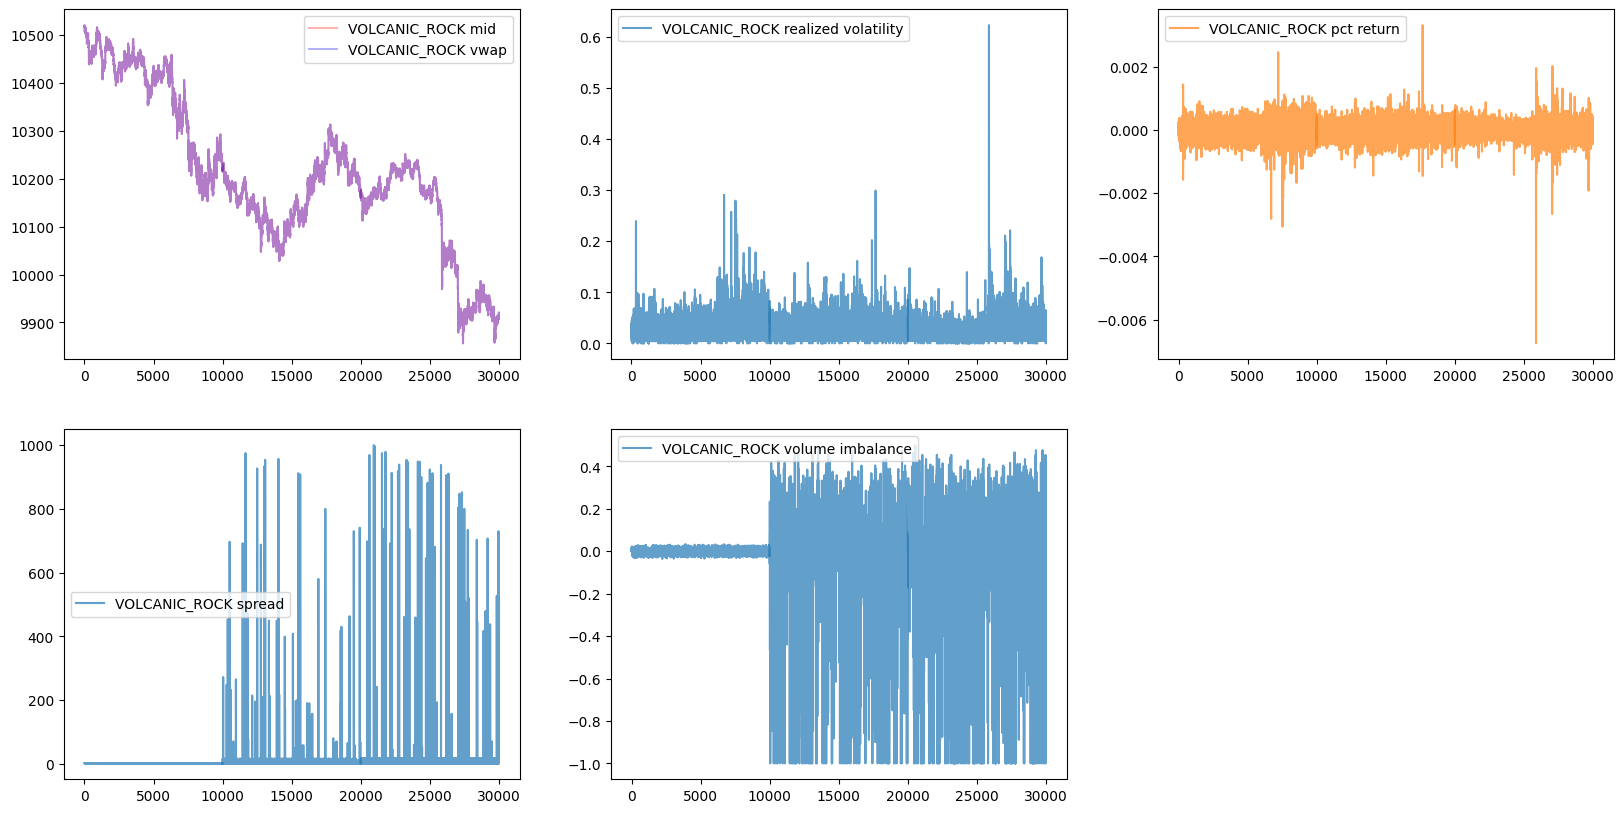

In [7]:
product = 'VOLCANIC_ROCK'
start = 0
plt.figure(figsize=(20, 10))
row, col = 2, 3
for day, df in enumerate([prices_1, prices_2, prices_3]):
    idx = df['product'] == product
    end = start+len(df['timestamp'][idx])-1
    plot_range = range(start, end+1)
    cnt = 1
    plt.subplot(row, col, cnt)
    cnt += 1
    plt.plot(plot_range, df['mid_price'][idx], label=f'{product} mid', alpha=0.3, c='r')
    plt.plot(plot_range, df['vwap'][idx], label=f'{product} vwap', alpha=0.3, c='b')
    # plt.plot(plot_range, df['mean_window3'][idx], label=f'{product} mean_window5', alpha=1, c='k')
    plt.yscale('log') if product == 'RAINFOREST_RESIN' else None
    plt.legend() if day == 0 else None
    plt.subplot(row, col, cnt)
    cnt += 1
    plt.plot(plot_range, df['realized_volatility_window3'][idx], label=f'{product} realized volatility', alpha=0.7, c='C0')
    plt.legend() if day == 0 else None
    plt.subplot(row, col, cnt)
    cnt += 1
    plt.plot(plot_range, df['pct_return'][idx], label=f'{product} pct return', alpha=0.7, c='C1')
    plt.legend() if day == 0 else None
    plt.subplot(row, col, cnt)
    cnt += 1
    plt.plot(plot_range, prices_1['spread'][idx], label=f'{product} spread', alpha=0.7, c='C0')
    plt.legend() if day == 0 else None
    plt.subplot(row, col, cnt)
    cnt += 1
    plt.plot(plot_range, prices_1['volume_imbalance'][idx], label=f'{product} volume imbalance', alpha=0.7, c='C0')
    plt.legend() if day == 0 else None
    start = end + 1

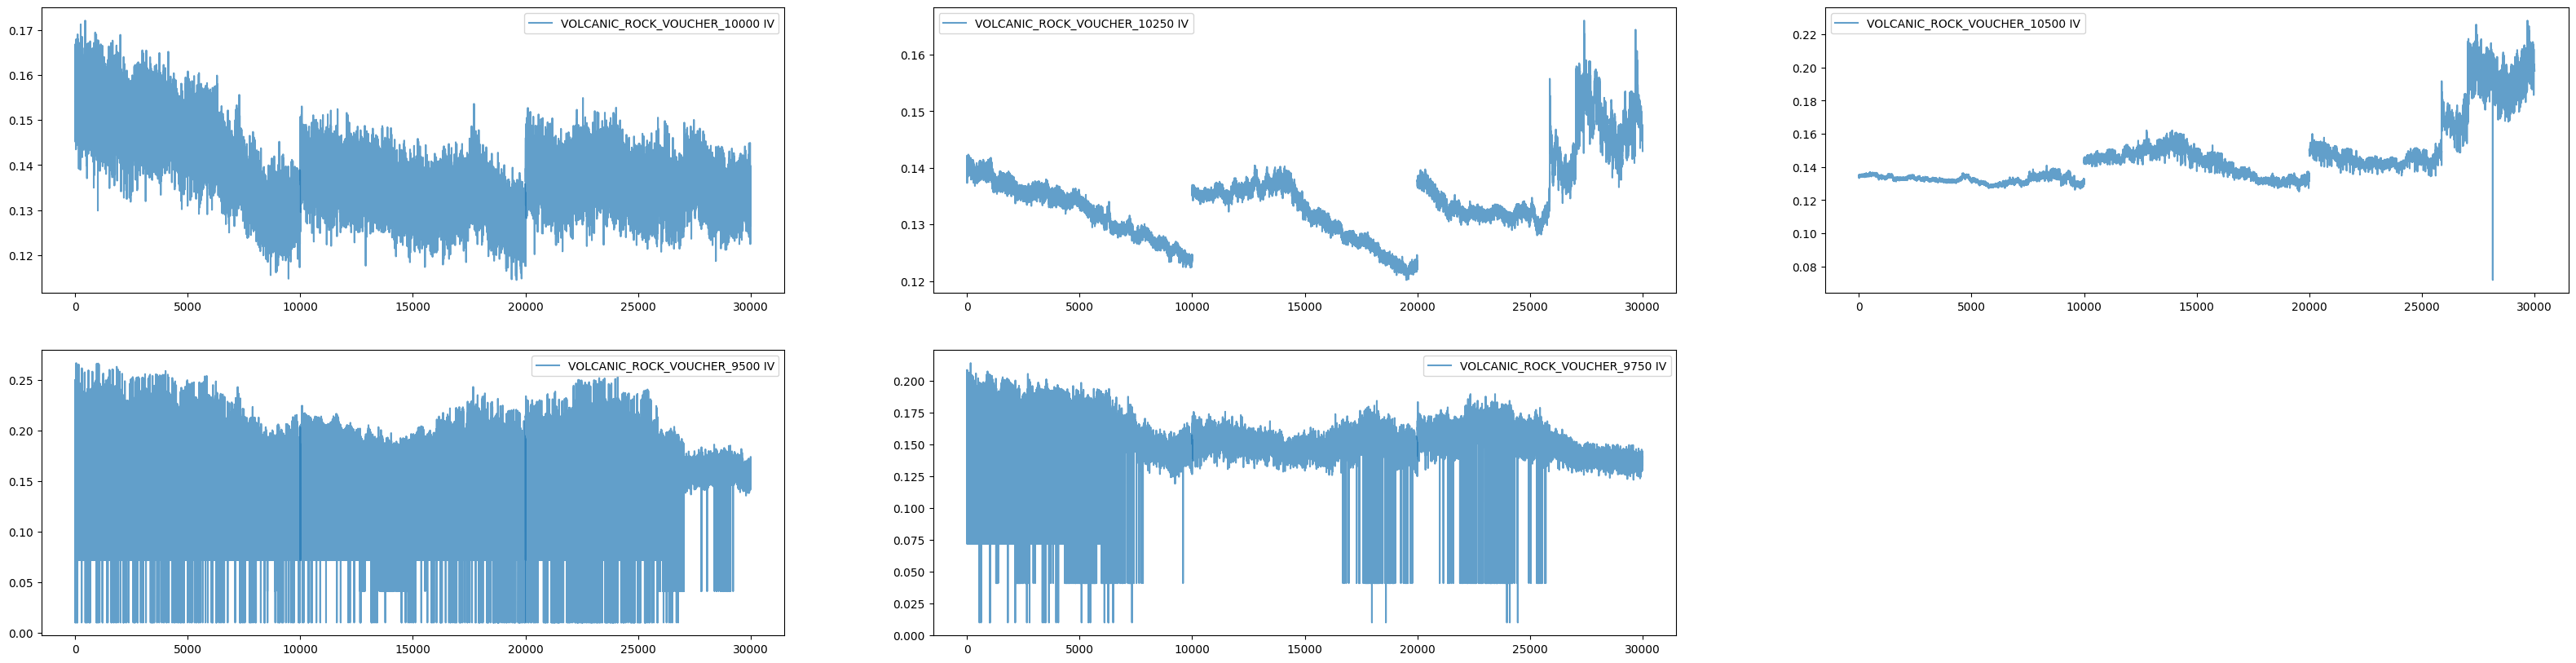

In [8]:
start = 0
plt.figure(figsize=(40, 10))
row, col = 2, 3
for day, df in enumerate([prices_1, prices_2, prices_3]):
    cnt = 1
    for option in OPTIONS:
        # plot iv
        idx = df['product'] == option
        end = start+len(df['timestamp'][idx])-1
        plot_range = range(start, end+1)
        plt.subplot(row, col, cnt)
        cnt += 1
        plt.plot(plot_range, df['implied_volatility'][idx], label=f'{option} IV', alpha=0.7, c='C0')
        plt.legend() if day == 0 else None
    start = end + 1

{10000: (0.31918784777187775, 0.031010845470092994, 0.13276129561696567), 10250: (0.314005460498095, -0.0003088858306615146, 0.13003255467654273), 10500: (0.4853390481422235, -0.07715874206061292, 0.1341271334040705), 9500: (0.5626823911753489, 0.6188948314352529, 0.3115365828886336), 9750: (-0.0353822056835982, -0.09186147950082771, 0.12614308032864555)}
{10000: 0.008474570370633957, 10250: 0.006851846108287582, 10500: 0.019223183823188248, 9500: 0.06663112163923171, 9750: 0.02579051730565845}


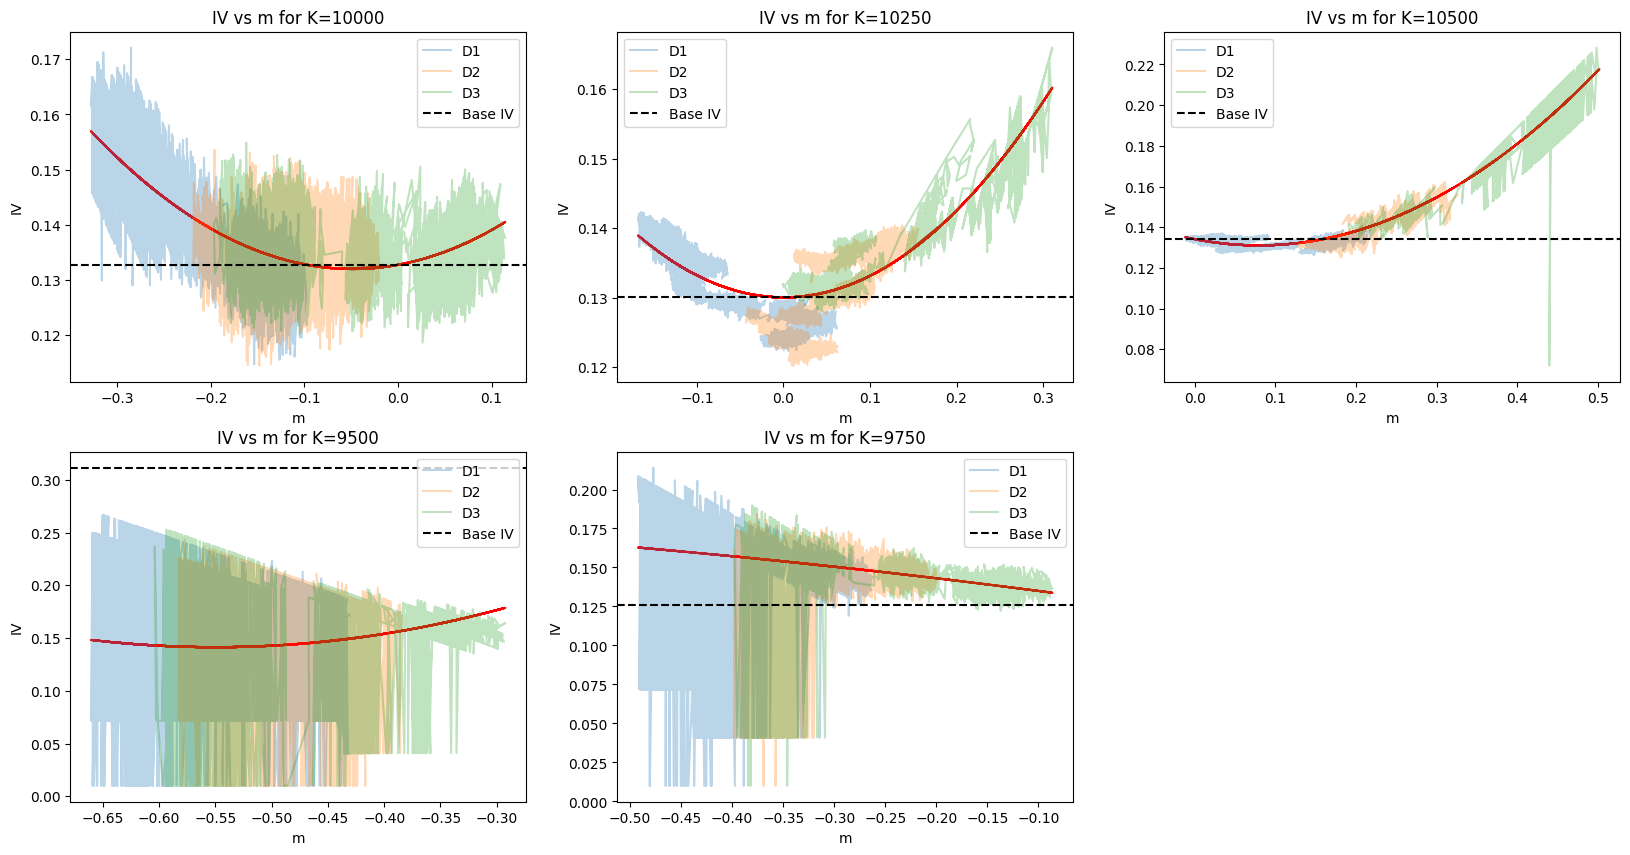

In [ ]:
spot_prices = np.zeros(30000)
# m_t = log(K/St)/ sqrt(tau)
m = {K: np.zeros(30000) for K in STRIKES}
IV = {K: np.zeros(30000) for K in STRIKES}
start = 0
for day, df in enumerate([prices_1, prices_2, prices_3]):
    end = start + 10000
    idx = df['product'] == 'VOLCANIC_ROCK'
    spot_prices[start:end] = df['mid_price'][idx].values
    S = spot_prices[start:end]
    time_to_expiry = TIME_TO_EXPIRY[day]
    for K in STRIKES:
        m[K][start:end] = np.log(K/S) / np.sqrt(time_to_expiry)
        idx = df['product'] == f'VOLCANIC_ROCK_VOUCHER_{K}'
        IV[K][start:end] = df['implied_volatility'][idx].values
        df.loc[idx, 'm'] = m[K][start:end]
    start = end

def parabolic_fit(x, y, return_coeffs=False):
    a, b, c = np.polyfit(x, y, 2)
    return a * x**2 + b * x + c if not return_coeffs else (a, b, c)

IV_fitted = {}
IV_polyfit_coeffs = {}
base_IV = {}
for K in STRIKES:
    IV_fitted[K] = parabolic_fit(m[K], IV[K])
    IV_polyfit_coeffs[K] = parabolic_fit(m[K], IV[K], return_coeffs=True)
    base_IV[K] = IV_polyfit_coeffs[K][2]

plt.figure(figsize=(20, 10))
row, col = 2, 3
cnt = 1
for K in STRIKES:
    plt.subplot(row, col, cnt)
    cnt += 1
    plt.plot(m[K][:10000], IV_fitted[K][:10000], 'r')
    plt.plot(m[K][:10000], IV[K][:10000], label=f'D1', alpha=0.3)
    plt.plot(m[K][10000:20000], IV_fitted[K][10000:20000], 'r')
    plt.plot(m[K][10000:20000], IV[K][10000:20000], label=f'D2',alpha=0.3)
    plt.plot(m[K][20000:], IV_fitted[K][20000:], 'r')
    plt.plot(m[K][20000:], IV[K][20000:] , alpha=0.3, label=f'D3')
    # # plot realized volatility
    # idx = prices_1['product'] == 'VOLCANIC_ROCK'
    # plt.plot(m[K][:10000], prices_1['realized_volatility_window10'][idx], label='Realized Volatility', alpha=0.7)
    # idx = prices_2['product'] == 'VOLCANIC_ROCK'
    # plt.plot(m[K][10000:20000], prices_2['realized_volatility_window10'][idx], label='Realized Volatility', alpha=0.7)
    # idx = prices_3['product'] == 'VOLCANIC_ROCK'
    # plt.plot(m[K][20000:], prices_3['realized_volatility_window10'][idx], label='Realized Volatility', alpha=0.7)
    # mark base IV
    plt.axhline(base_IV[K], color='k', linestyle='--', label='Base IV')
    plt.xlabel('m')
    plt.ylabel('IV')
    plt.title(f'IV vs m for K={K}')
    plt.legend()

# # plot iv vs m for each option
# plt.figure(figsize=(20, 10))
# row, col = 2, 3
# start = 0
# for day, df in enumerate([prices_1, prices_2, prices_3]):
#     cnt = 1
#     end = start + 10000
#     for K in STRIKES:
#         option = f'VOLCANIC_ROCK_VOUCHER_{K}'
#         idx = df['product'] == option
#         plt.subplot(row, col, cnt)
#         cnt += 1
#         plt.plot(m[K][start:end], df['implied_volatility'][idx], label=f'Day {day}', alpha=0.7)
#         plt.xlabel('m')
#         plt.ylabel('IV')
#         plt.title(option)
#         plt.legend() if day == 0 else None
#     end = start

IV_std = {}
for K in STRIKES:
    IV_std[K] = np.std(IV[K])
print(IV_polyfit_coeffs)
print(IV_std)

In [ ]:
m_trading_region = {
    9500: (-0.7, -0.375),
    9750: (-0.5, -0.325),
    10000: (-0.35, 0.125),
}
IV_std_est = {
    9500: 0.05,
    9750: 0.4,
}

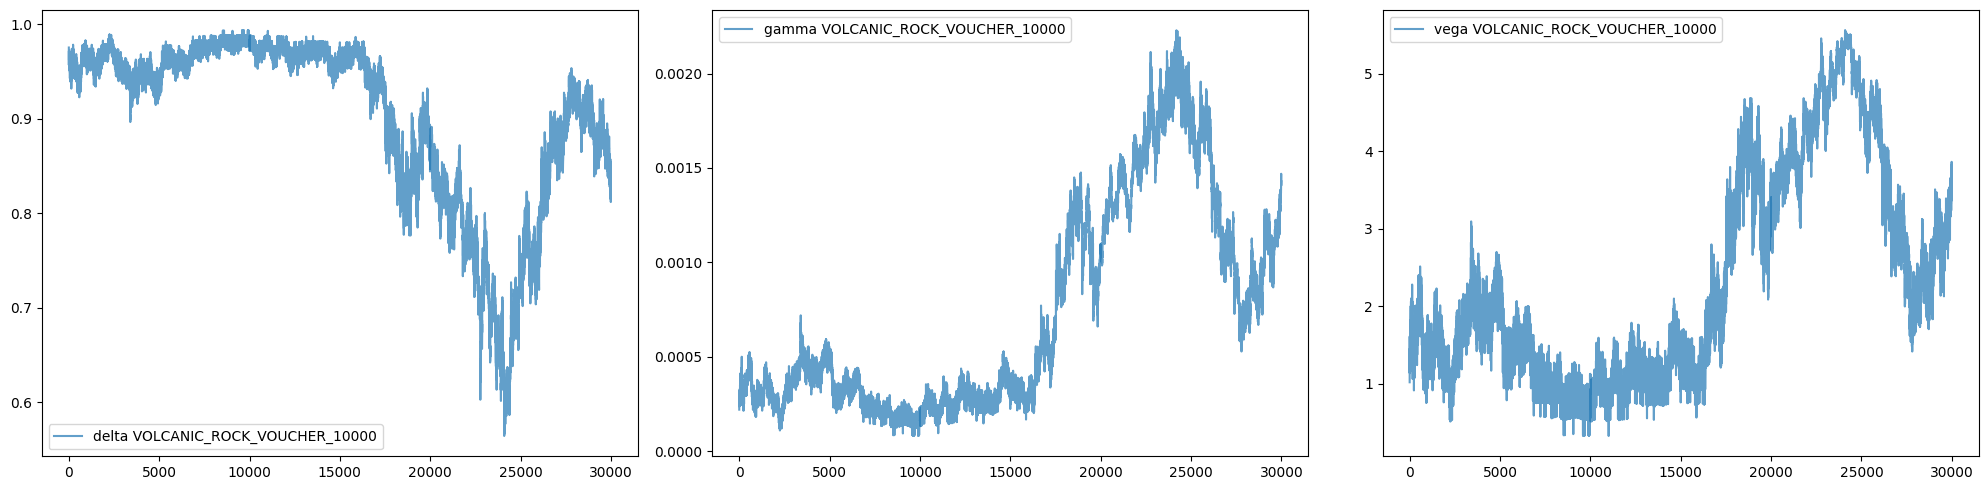

In [41]:
# plot greeks
GREEKS = ['delta', 'gamma', 'vega']
start = 0
plt.figure(figsize=(20, 5))
row, col = 1, 3
for day, df in enumerate([prices_1, prices_2, prices_3]):
    cnt = 1
    for greek in GREEKS:
        # plot iv
        idx = df['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'
        end = start+len(df['timestamp'][idx])-1
        plot_range = range(start, end+1)
        plt.subplot(row, col, cnt)
        cnt += 1
        plt.plot(plot_range, df[greek][idx], label=f'{greek} VOLCANIC_ROCK_VOUCHER_10000', alpha=0.7, c='C0')
        plt.legend() if day == 0 else None
    start = end + 1
plt.tight_layout()
plt.show()

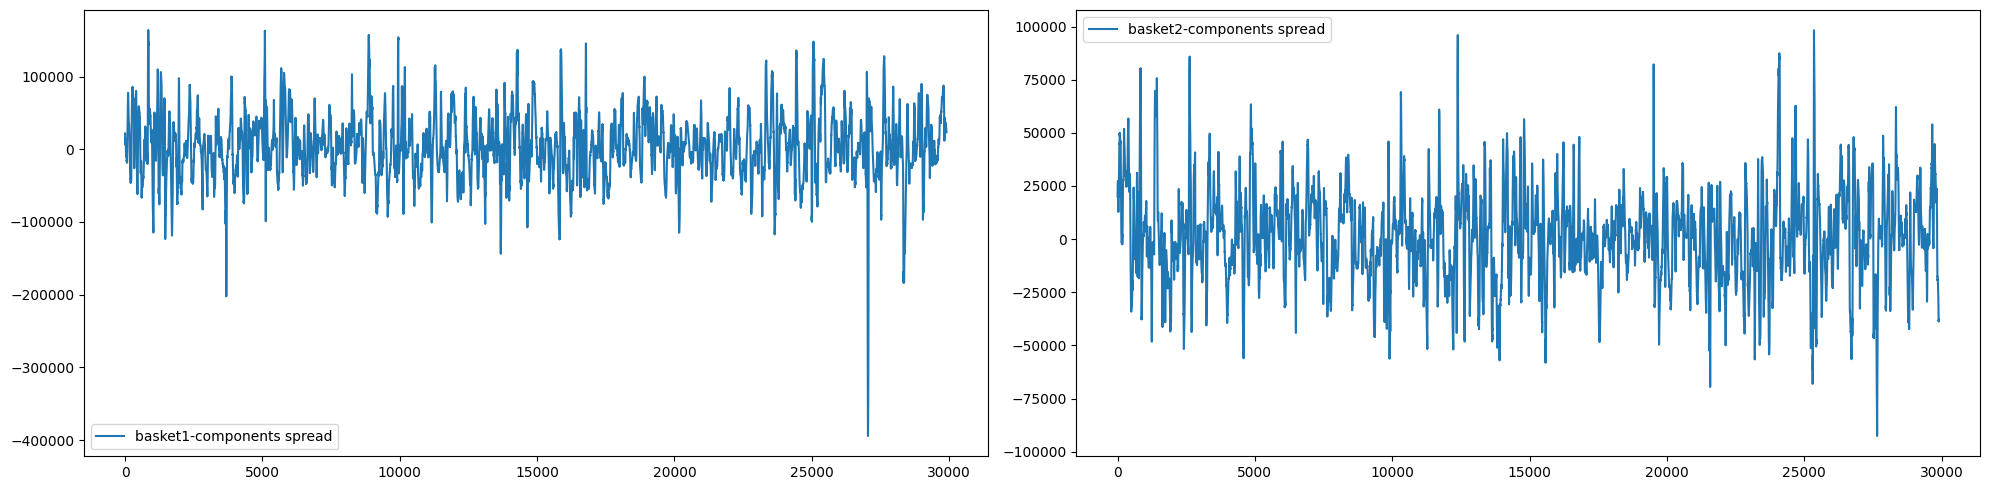

Spread 1
--------------------
ADF statistic: -18.137
p-value: 0.000
Stationary at 0.05 significance level
Mean: 3734.687
Standard Deviation: 43603.895

Spread 2
--------------------
ADF statistic: -16.234
p-value: 0.000
Stationary at 0.05 significance level
Mean: 1360.219
Standard Deviation: 21461.047


In [55]:
BASKET1 = 'PICNIC_BASKET1'
BASKET1_COMPONENTS = {
    'CROISSANTS': 6,
    'JAMS': 3,
    'DJEMBES': 1
}
BASKET2 = 'PICNIC_BASKET2'
BASKET2_COMPONENTS = {
    'CROISSANTS': 4,
    'JAMS': 2,
}

basket1_prices = np.array([])
basket2_prices = np.array([])
for df in [prices_1, prices_2, prices_3]:
    basket1_prices = np.append(basket1_prices, df[df['product'] == BASKET1]['mid_price'].values)
    basket2_prices = np.append(basket2_prices, df[df['product'] == BASKET2]['mid_price'].values)
components1_prices = np.zeros_like(basket1_prices)
components2_prices = np.zeros_like(basket2_prices)
start = 0
end = 10000
for df in [prices_1, prices_2, prices_3]:
    for component, quantity in BASKET1_COMPONENTS.items():
        components1_prices[start:end] += df[df['product'] == component]['mid_price'].values * quantity
    for component, quantity in BASKET2_COMPONENTS.items():
        components2_prices[start:end] += df[df['product'] == component]['mid_price'].values * quantity
    start = end
    end += 10000

hedge_ratio1 = []
hedge_ratio2 = []
window = 100
for i in range(window, len(basket1_prices)):
    y = basket1_prices[i-window:i]
    x = components1_prices[i-window:i]
    hedge_ratio1.append(linear_regression(x, y)[0])
    y = basket2_prices[i-window:i]
    x = components2_prices[i-window:i]
    hedge_ratio2.append(linear_regression(x, y)[0])
hedge_ratio1 = np.array(hedge_ratio1)
hedge_ratio2 = np.array(hedge_ratio2)
spread1 = basket1_prices[window:] - hedge_ratio1 * components1_prices[window:]
spread2 = basket2_prices[window:] - hedge_ratio2 * components2_prices[window:]

# hedge_ratio1 = linear_regression(
#     components1_prices, basket1_prices)[0]
# hedge_ratio2 = linear_regression(
#     components2_prices, basket2_prices)[0]
# spread1 = basket1_prices - hedge_ratio1 * components1_prices
# spread2 = basket2_prices - hedge_ratio2 * components2_prices

# spread1 = basket1_prices - components1_prices
# spread2 = basket2_prices - components2_prices

# plot spreads
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(spread1, label='basket1-components spread')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(spread2, label='basket2-components spread')
plt.legend()
plt.tight_layout()
plt.show()

# stationarity test
print('Spread 1')
print('-'*20)
stationarity_test(spread1)
print('\nSpread 2')
print('-'*20)
stationarity_test(spread2)


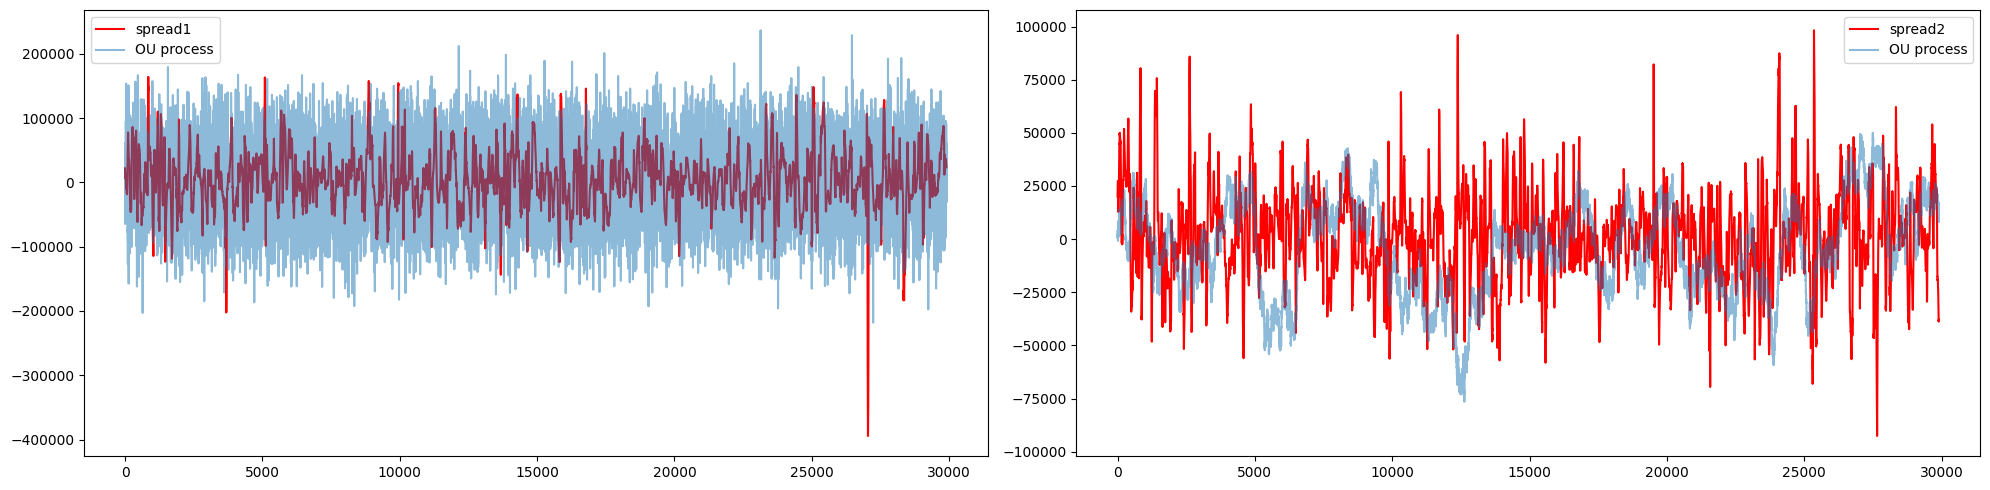

In [58]:
# Fit the spreads by OU process
theta1, mu1, sig1 = estimate_ou_mle(spread1)
theta2, mu2, sig2 = estimate_ou_mle(spread2)
ou_process1 = ou_process(theta1, mu1, sig1, n_steps=len(spread1))
ou_process2 = ou_process(theta2, mu2, sig2, n_steps=len(spread2))
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(spread1, label='spread1', c='r')
plt.plot(ou_process1, label='OU process', alpha=0.5)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(spread2, label='spread2', c='r')
plt.plot(ou_process2, label='OU process', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()